In [9]:
import os
import sys
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt
sys.path.append(os.path.join(os.getcwd(), 'common'))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.1
np.random.seed(seed=123)

# image = cv2.imread(img_path, 0)

In [10]:
def embedding(image, mark_size, alpha, v='multiplicative'):
    # Get the DCT transform of the image
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    sign = np.sign(ori_dct)
    ori_dct = abs(ori_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    # Embed the watermark
    watermarked_dct = ori_dct.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            watermarked_dct[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_dct[loc] *= 1 + ( alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_dct *= sign
    watermarked = np.uint8(idct(idct(watermarked_dct,axis=1, norm='ortho'),axis=0, norm='ortho'))#NEED to convert to integeger, because we would be able to plot with real and complex number

    return mark, watermarked


# mark, watermarked = embedding(image, N, alpha, v)
# cv2.imwrite('watermarked.bmp', watermarked)

In [11]:
def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  csf = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(csf,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

# Plot the two images side by side
# plt.figure(figsize=(15, 6))
# plt.subplot(121)
# plt.title('Original')
# plt.imshow(image, cmap='gray')
# plt.subplot(122)
# plt.title('Watermarked')
# plt.imshow(watermarked,cmap='gray')
# plt.show()

# Compute quality
# psnr = cv2.PSNR(image, watermarked)
# print('PSNR: %.2fdB' % psnr)
# w = wpsnr(image, watermarked)
# print('wPSNR: %.2fdB' % w)


In [12]:
def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    ori_dct = abs(ori_dct)
    wat_dct = abs(wat_dct)
    locations = np.argsort(-ori_dct,axis=None) # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations[1:mark_size+1]):
        if v=='additive':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) /alpha
        elif v=='multiplicative':
            w_ex[idx] =  (wat_dct[loc] - ori_dct[loc]) / (alpha*ori_dct[loc])
            
    return w_ex

# w_ex = detection(image, watermarked, alpha, N, v)

In [13]:
def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s

def compute_thr(sim, mark_size, w):
    SIM = np.zeros(1000)
    for i in range(1, 1000):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    print('threshold: ', T)
    return T

# sim = similarity(mark, w_ex)
# T = compute_thr(sim, N, mark)

# if sim > T:
#     print('Mark has been found. SIM = %f' % sim)
# else:
#     print('Mark has been lost. SIM = %f' % sim)

## PIPELINE

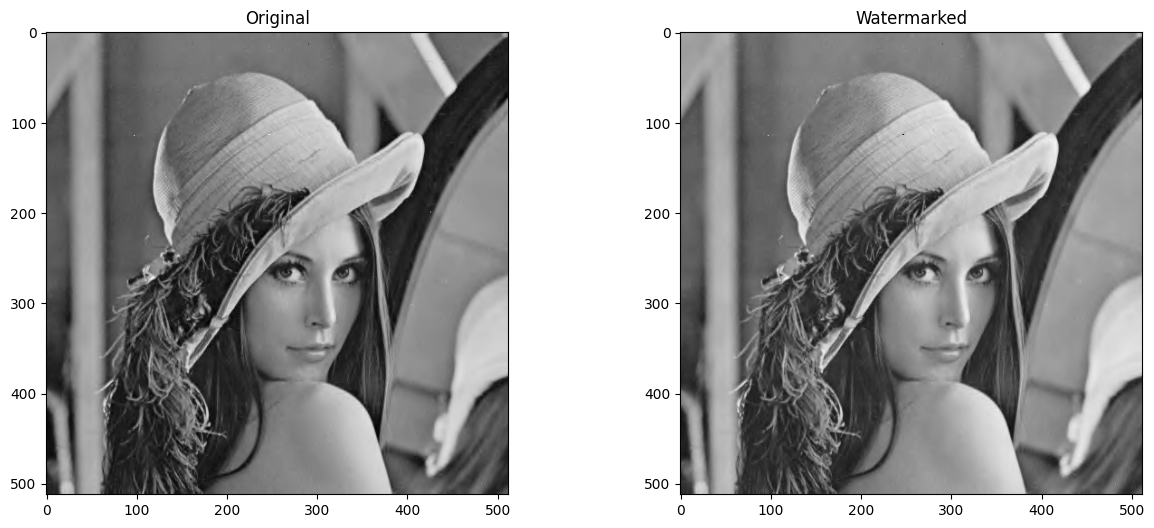

PSNR: 37.65dB
wPSNR: 44.20dB
threshold:  0.7155977263270926
Mark has been found. SIM = 0.997930


In [14]:


# load the image
image = cv2.imread(img_path, 0)

#Embed the watermark and save it
mark, watermarked = embedding(image, N, alpha, v)

#plot the original and watermarked image
cv2.imwrite('watermarked.bmp', watermarked)
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title('Watermarked')
plt.imshow(watermarked,cmap='gray')
plt.show()

#check the quality of the watermarked image with respect to the original image
psnr = cv2.PSNR(image, watermarked)
print('PSNR: %.2fdB' % psnr)
w = wpsnr(image, watermarked)
print('wPSNR: %.2fdB' % w)


#Detect the watermark
w_ex = detection(image, watermarked, alpha, N, v)

#Compute the similarity and threshold
sim = similarity(mark, w_ex)
T = compute_thr(sim, N, mark)

if sim > T:
    print('Mark has been found. SIM = %f' % sim)
else:
    print('Mark has been lost. SIM = %f' % sim)

## Attack

In [16]:

import importlib
import attacks 
from detection import detection, similarity

# Reload the entirea module, not the function
importlib.reload(attacks)

(history, best) = attacks.multiple_attacks(watermarked)
# print("history")
# print(history)




Applying AWGN:   0%|          | 0/6 [00:00<?, ?it/s]   

Applying JPEG Compression: 100%|██████████| 6/6 [00:14<00:00,  2.42s/it]

Best attack: JPEG Compression, PSNR: 38.25543938061093, WPSNR: 53.3482697244228, Params: QF: 57


In [17]:
alpha = 1.7
mark = np.load('ammhackati.npy')
for attack_name,attack in history.items():
    for attacked_image in attack:
        print("Attack: ", attacked_image['attacked_image'].shape,image.shape)
        w_ex = detection(image, attacked_image['attacked_image'], alpha)
        for w in w_ex:

            sim = similarity(mark, w)
            if sim > T:
                print('Mark has been found. SIM = %f' % sim)
                print("Attack: ", attack_name)
            else:
                print('Mark has been lost. SIM = %f' % sim)
                print("Attack: ", attack_name)

Attack:  (512, 512) (512, 512)


TypeError: 'NoneType' object is not iterable

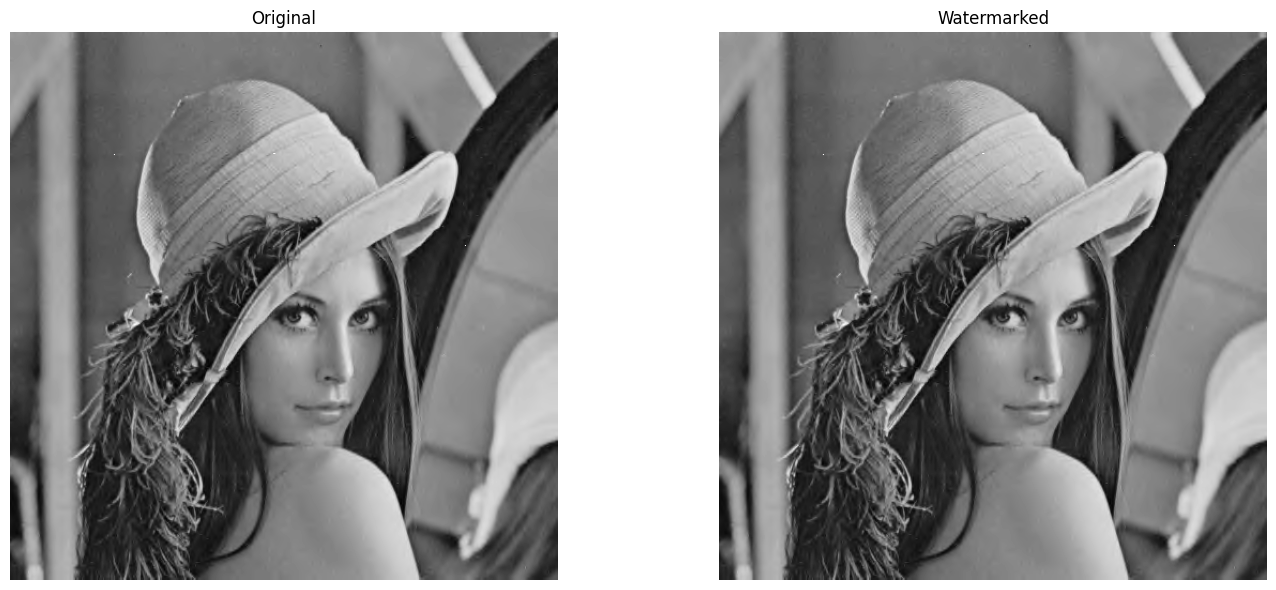

In [46]:
import pywt


def create_perceptual_mask(subband):

    mask = np.ones(subband.shape)
    mask = compute_brightness_sensitivity(subband) * compute_edge_sensitivity(subband) * compute_texture_sensitivity(subband)
    
    return mask

def compute_brightness_sensitivity(subband):

    # Normalize brightness between 0 and 1
    min_brightness = np.min(subband)
    max_brightness = np.max(subband)
    brightness_sensitivity = (subband - min_brightness) / (max_brightness - min_brightness + 1e-6)
    
    # Invert to give higher sensitivity in dark areas (lower brightness = higher mask value)
    return 1 - brightness_sensitivity

def compute_edge_sensitivity(subband):

    # Compute image gradient (strong edges correspond to higher gradients)
    sobel_x = cv2.Sobel(subband, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(subband, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalize gradient magnitude between 0 and 1
    gradient_sensitivity = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude) + 1e-6)
    
    return gradient_sensitivity

def compute_texture_sensitivity(subband):
    
    # Compute local variance as a measure of texture
    mean = cv2.blur(subband, (3, 3))
    local_variance = cv2.blur((subband - mean) ** 2, (3, 3))
    
    # Normalize local variance between 0 and 1
    texture_sensitivity = (local_variance - np.min(local_variance)) / (np.max(local_variance) - np.min(local_variance) + 1e-6)
    
    return texture_sensitivity

def modular_alpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def get_locations(subband):
    sign = np.sign(subband)
    abs_subband = abs(subband)
    locations = np.argsort(-abs_subband,axis=None) # - sign is used to get descending order
    rows = subband.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    return abs_subband, sign, locations

def embed_watermark(subband, mark, layer, theta, alpha=0.5, v='multiplicative'):

    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband) 

    watermarked = abs_subband.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            x = locations[idx][0]
            y = locations[idx][1]
            watermarked[loc] += (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
        elif v == 'multiplicative':
            x = locations[idx][0]
            y = locations[idx][1]
            watermarked[loc] *= 1 + (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
    
    return sign, watermarked

def recursive_embedding(coeffs, mark, alpha, level, max_level, v='multiplicative'):
    LL, (LH, HL, HH) = coeffs

    # Base case: if we reach level 3, embed the watermark and return
    if level == max_level:
        sign_LH, watermarked_LH = embed_watermark(LH, mark, level, 0, alpha, v)
        sign_HL, watermarked_HL = embed_watermark(HL, mark, level, 1, alpha, v)
        sign_HH, watermarked_HH = embed_watermark(HH, mark, level, 2, alpha, v)

        # Apply the sign and return the inverse DWT
        watermarked_LH *= sign_LH
        watermarked_HL *= sign_HL
        watermarked_HH *= sign_HH

        watermarked_LL = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
        return watermarked_LL

    # Recursive case: perform another DWT and recurse
    coeffs_next = pywt.dwt2(LL, 'haar')
    watermarked_LL = recursive_embedding(coeffs_next, mark, alpha, level + 1, max_level, v)

    # Embed the watermark at this level
    sign_LH, watermarked_LH = embed_watermark(LH, mark, level, 0, alpha, v)
    sign_HL, watermarked_HL = embed_watermark(HL, mark, level, 1, alpha, v)
    sign_HH, watermarked_HH = embed_watermark(HH, mark, level, 2, alpha, v)

    # Apply the sign to the watermarked coefficients
    watermarked_LH *= sign_LH
    watermarked_HL *= sign_HL
    watermarked_HH *= sign_HH

    # Return the inverse DWT of the watermarked image
    watermarked = pywt.idwt2((watermarked_LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
    return watermarked


def embedding(image, mark, alpha, max_level=2, v='multiplicative'):
    # Initial wavelet decomposition
    coeffs = pywt.dwt2(image, 'haar')
    
    # Start recursive embedding from level 0
    watermarked_image = recursive_embedding(coeffs, mark, alpha, level=0, max_level=max_level, v=v)
    
    return watermarked_image

alpha = 1.7
wm = embedding(image, mark, alpha)

from utility import visualize_images_with_desc
visualize_images_with_desc([image, wm], ['Original', 'Watermarked'])





In [20]:
import importlib
import attacks as attacks
from detection import detection, similarity

# Reload the entire module, not the function
importlib.reload(attacks)

(history, best) = attacks.multiple_attacks(wm)

Applying JPEG Compression: 100%|██████████| 6/6 [00:13<00:00,  2.27s/it]

Best attack: AWGN, PSNR: 46.937785294948426, WPSNR: 58.76737609326062, Params: std: 1


In [41]:
# alpha = 1.7
# mark = np.load('ammhackati.npy')
# for attack_name,attack in history.items():
#     for attacked_image in attack:
#         print("Attack: ", attacked_image['attacked_image'].shape,image.shape)
#         w_ex = detection(image, attacked_image['attacked_image'], alpha)
#         for w in w_ex:

#             sim = similarity(mark, w)
#             if sim > T:
#                 print('Mark has been found. SIM = %f' % sim)
#                 print("Attack: ", attack_name)
#             else:
#                 print('Mark has been lost. SIM = %f' % sim)
#                 print("Attack: ", attack_name)

Attack:  (512, 512) (512, 512)


ValueError: operands could not be broadcast together with shapes (1024,) (1023,) 

Applying JPEG Compression: 100%|██████████| 6/6 [00:14<00:00,  2.50s/it]


Best attack: JPEG Compression, PSNR: 41.71730604026793, WPSNR: 59.755802249643395, Params: QF: 81
{'mean_psnr': 24.727436036076583, 'mean_wpsnr': 34.70058878119204, 'best_wpsnr': 59.755802249643395, 'worst_wpsnr': 11.652951278477603}


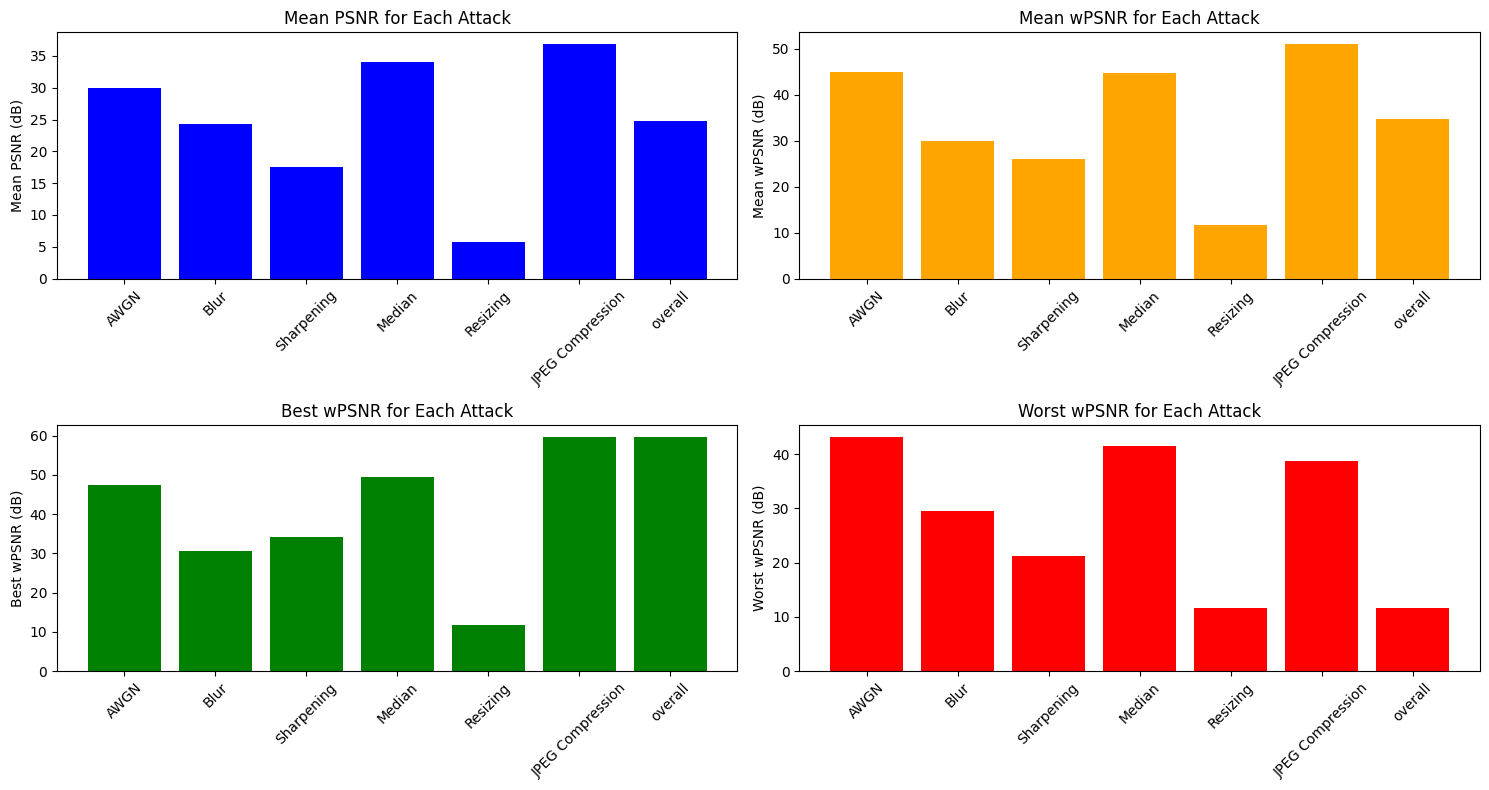

In [21]:


# Reload the entire module, not the function
importlib.reload(attacks)

(history,_) = attacks.multiple_attacks(wm)
#print(history)
stats = attacks.stats(history)
print(stats['overall'])
attacks.plot_stats(stats)

# FULL PIPELINE

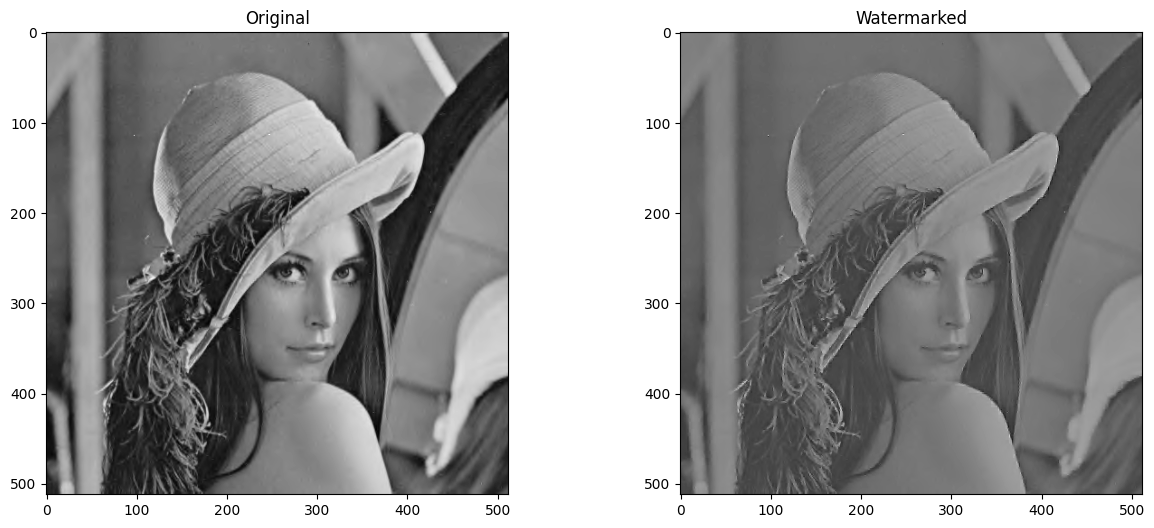

wPSNR: 42.50dB
./sample_imgs/0086.bmp
(512, 512)
0.9


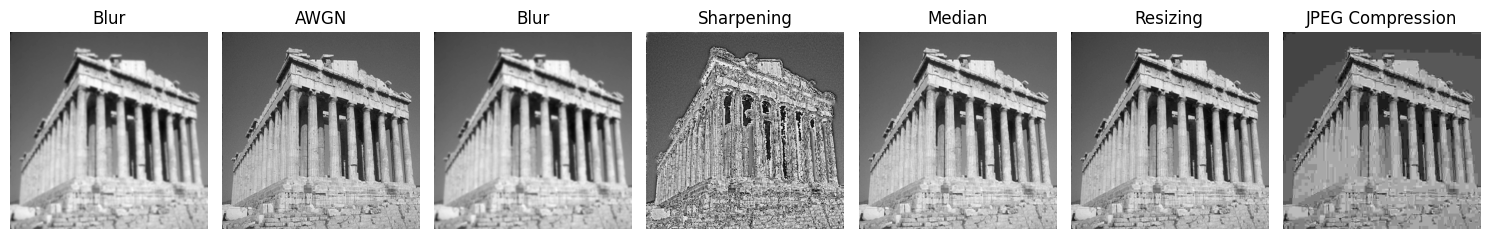

Applying Resizing:  67%|██████▋   | 4/6 [00:13<00:07,  3.52s/it]  

(512, 512)
0.8987225697359849


Applying Resizing:  67%|██████▋   | 4/6 [00:14<00:07,  3.52s/it]

(512, 512)
0.57325930964509


Applying Resizing:  67%|██████▋   | 4/6 [00:15<00:07,  3.52s/it]

(512, 512)
0.8528875073065763


Applying JPEG Compression: 100%|██████████| 6/6 [00:18<00:00,  3.16s/it]


Best attack: AWGN, PSNR: 46.87567128821083, WPSNR: 58.32606852691998, Params: std: 1
{'AWGN': [{'psnr': 27.52424127335938, 'wpsnr': 39.8052044139352, 'params': 'std: 5', 'attacked_image': array([[166, 164, 165, ..., 160, 164, 135],
       [171, 159, 157, ..., 175, 156, 144],
       [159, 157, 162, ..., 162, 161, 135],
       ...,
       [ 46,  35,  44, ..., 104,  93, 102],
       [ 44,  48,  41, ..., 101, 106, 107],
       [ 45,  40,  53, ..., 106, 110,  94]], dtype=uint8)}, {'psnr': 29.032625985521815, 'wpsnr': 44.092044020358784, 'params': 'std: 9', 'attacked_image': array([[178, 157, 163, ..., 171, 176, 147],
       [167, 172, 153, ..., 180, 154, 134],
       [166, 152, 151, ..., 160, 158, 136],
       ...,
       [ 53,  45,  28, ..., 116, 104,  89],
       [ 57,  51,  69, ..., 104,  86, 111],
       [ 44,  48,  52, ...,  91, 123, 101]], dtype=uint8)}, {'psnr': 46.87567128821083, 'wpsnr': 58.32606852691998, 'params': 'std: 1', 'attacked_image': array([[160, 162, 157, ..., 169, 165, 

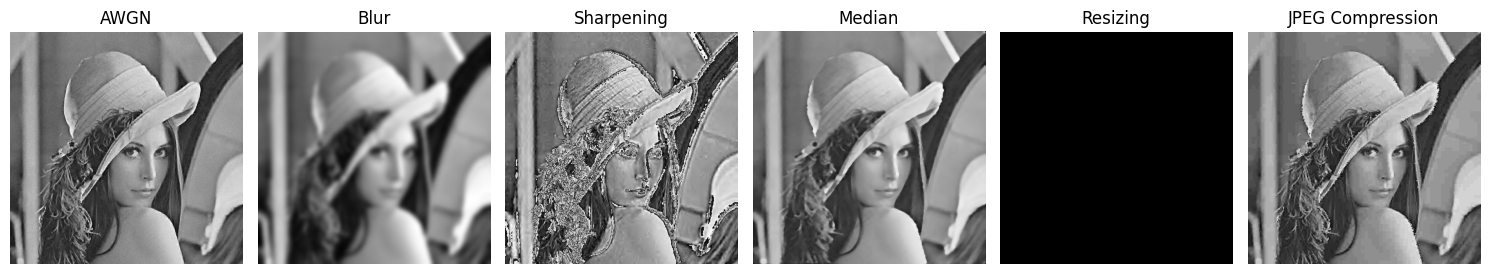

{'mean_psnr': 23.52085299746822, 'mean_wpsnr': 34.39947399639434, 'best_wpsnr': 58.32606852691998, 'worst_wpsnr': 11.634496516155817, 'total_lost': 0}


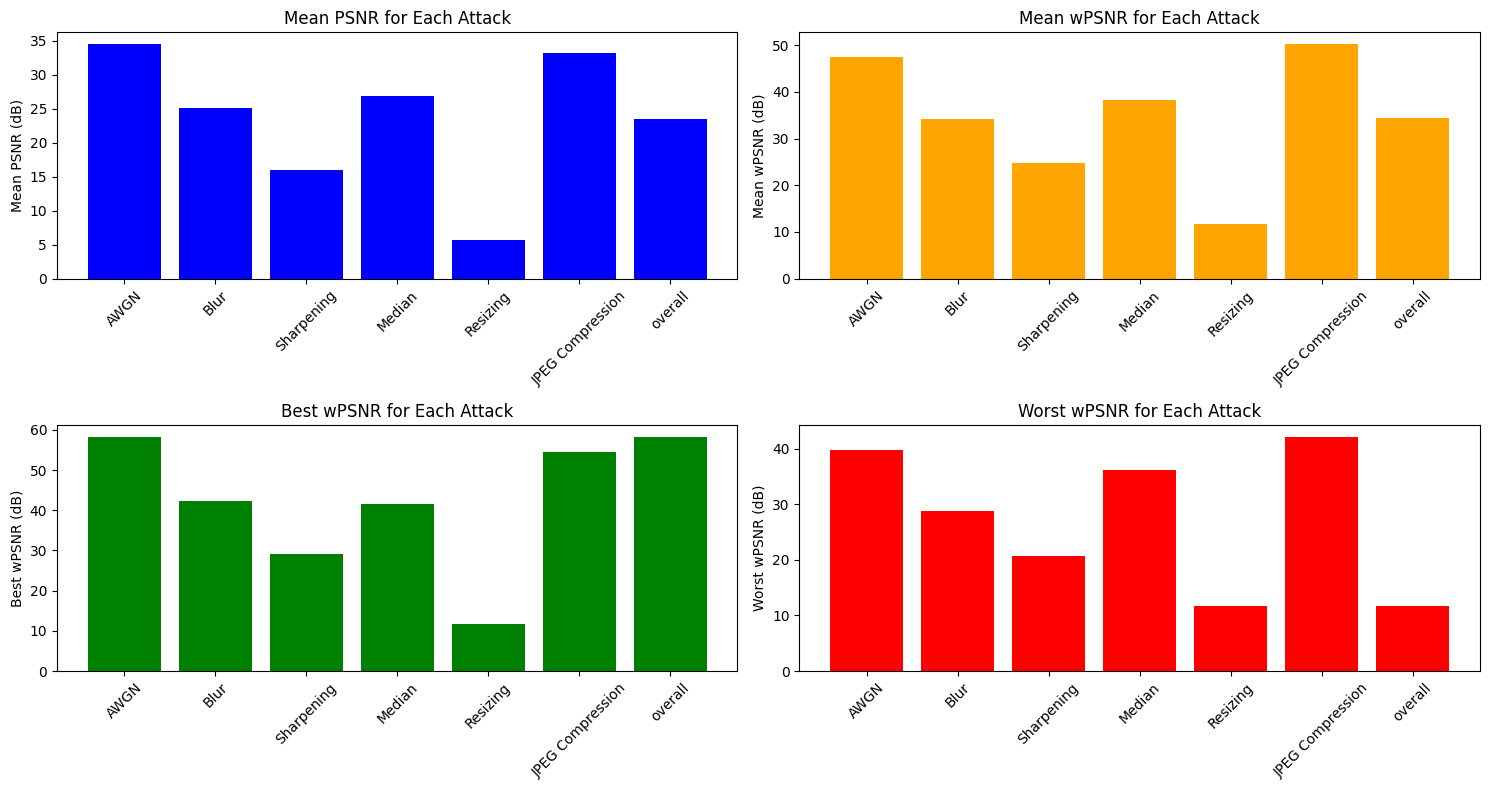

In [73]:
import os
import sys
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt
sys.path.append(os.path.join(os.getcwd(), 'common'))
from utility import wpsnr
import embedding as emb
from detection import detection, similarity, compute_thr
import importlib
import attacks 
import utility
import random


# Reload the entirea module, not the function
importlib.reload(attacks)


img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.8
np.random.seed(seed=123)
mark = np.load('ammhackati.npy')






# load the image
image = cv2.imread(img_path, 0)

#Embed the watermark and save it
watermarked = emb.embedding(image, mark, alpha)

#plot the original and watermarked image
cv2.imwrite('watermarked.bmp', watermarked)
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title('Watermarked')
plt.imshow(watermarked,cmap='gray')
plt.show()

#check the quality of the watermarked image with respect to the original image
# psnr = cv2.PSNR(image, watermarked)
# print('PSNR: %.2fdB' % psnr)
w = wpsnr(image, watermarked)
print('wPSNR: %.2fdB' % w)


# #Detect the watermark
# w_ex = detection(image, watermarked, alpha)

# #Compute the similarity and threshold
# sim = similarity(mark, max(w_ex))
# T = 0.7#compute_thr(sim, N, mark)

# if sim > T:
#     print('Mark has been found. SIM = %f' % sim)
# else:
#     print('Mark has been lost. SIM = %f' % sim)
    


rand = random.randint(0, 100)
offset = "00" if rand < 10 else "0"
path = "./sample_imgs/0"+offset+str(rand)+".bmp"
print(path)
attacked_image = attacks.attacks(path, "Blur", [2])
attacked_image1 = attacks.attacks(path, "AWGN", [2])
attacked_image2 = attacks.attacks(path, "Blur", [2])
attacked_image3 = attacks.attacks(path, "Sharpening", [4, 3])
attacked_image4 = attacks.attacks(path, "Median", [3, 3])
attacked_image5 = attacks.attacks(path, "Resizing", [0.9])
attacked_image6 = attacks.attacks(path, "JPEG Compression", [5])
utility.visualize_images_with_desc([attacked_image,attacked_image1,attacked_image2,attacked_image3,attacked_image4,attacked_image5,attacked_image6], ['Blur','AWGN','Blur','Sharpening','Median','Resizing','JPEG Compression'])
# attacks(image_path, attack_name, param_array)
# attacked_image = attacks("path_to_image.jpg", "AWGN", [std])
# attacked_image = attacks("path_to_image.jpg", "Blur", [sigma])
# attacked_image = attacks("path_to_image.jpg", "Sharpening", [sigma, alpha])
# attacked_image = attacks("path_to_image.jpg", "Median", [kernel_size_w, kernel_size_h])
# attacked_image = attacks("path_to_image.jpg", "Resizing", [scale])
# attacked_image = attacks("path_to_image.jpg", "JPEG Compression", [QF])

(history, best) = attacks.multiple_attacks(watermarked)  
print(history) 

a_img = [entries[0]['attacked_image'] for attack_name, entries in history.items()]

a_label = history.keys()
utility.visualize_images_with_desc(a_img, a_label)
stats = attacks.stats(history)
print(stats['overall'])
attacks.plot_stats(stats)



 # Embedding and detection of lab3



WPSNR non-ATTACKED IMAGE =  62.78562248513153
WPSNR ATTACKED IMAGE =  39.7389669856196


Mark has been found in the non-attacked image. SIM = 1.000000
Mark has been lost in the attacked image. SIM = 0.667014
--------------------------




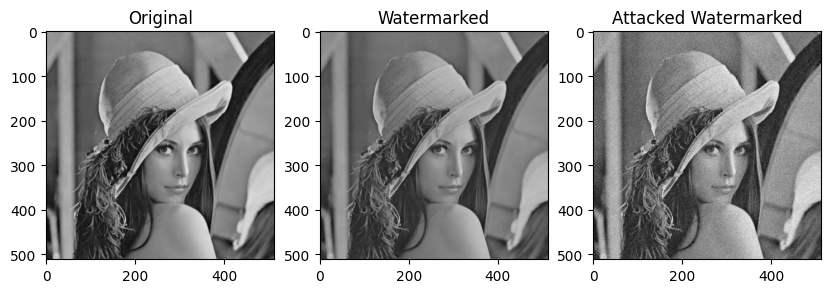

In [112]:
#5
import pywt
import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from math import sqrt

def similarity(X,X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / (np.sqrt(np.sum(np.multiply(X, X))) * np.sqrt(np.sum(np.multiply(X_star, X_star))))
    return s


def compute_thr(sim, mark_size, w, N):
    SIM = np.zeros(N)
    for i in range(N):
        r = np.random.uniform(0.0, 1.0, mark_size)
        SIM[i] = (similarity(w, r))
    SIMs = SIM.copy()
    SIM.sort()
    t = SIM[-1]
    T = t + (0.1*t)
    #print('Threshold: ', T)
    return T, SIMs
#select your attack 

def awgn(img, std, seed):
  mean = 0.0   # some constant
  np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return np.uint8(attacked)

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

def embedding(image, mark_size, alpha, v='multiplicative'):

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2

    # Get the locations in LH
    sign_LH = np.sign(LH)
    abs_LH = abs(LH)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL)
    abs_HL = abs(HL)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH)
    abs_HH = abs(HH)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates
    # Embed the watermark in LH
    watermarked_LH = abs_LH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_LH[1:], mark)):
        if v == 'additive':
            watermarked_LH[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_LH[loc] *= 1 + ( alpha * mark_val)
    
     # Embed the watermark in LH
    watermarked_HL = abs_HL.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HL[1:], mark)):
        if v == 'additive':
            watermarked_HL[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HL[loc] *= 1 + ( alpha * mark_val)
    
     # Embed the watermark in LH
    watermarked_HH = abs_HH.copy()
    for idx, (loc,mark_val) in enumerate(zip(locations_HH[1:], mark)):
        if v == 'additive':
            watermarked_HH[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_HH[loc] *= 1 + ( alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_LH *= sign_LH
    watermarked_HL *= sign_HL
    watermarked_HH *= sign_HH
    watermarked = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')

    return mark, watermarked

def detection(image, watermarked, alpha, mark_size, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(image, 'haar')
    LL_or, (LH_or, HL_or, HH_or) = coeffs2
    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    coeffs2 = pywt.dwt2(watermarked, 'haar')
    LL_w, (LH_w, HL_w, HH_w) = coeffs2

    #
    # Get the locations in LH
    sign_LH = np.sign(LH_or)
    abs_LH = abs(LH_or)
    locations_LH = np.argsort(-abs_LH,axis=None) # - sign is used to get descending order
    rows_LH = LH_or.shape[0]
    locations_LH = [(val//rows_LH, val%rows_LH) for val in locations_LH] # locations as (x,y) coordinates

    # Get the locations in HL
    sign_HL = np.sign(HL_or)
    abs_HL = abs(HL_or)
    locations_HL = np.argsort(-abs_HL,axis=None) # - sign is used to get descending order
    rows_HL = HL_or.shape[0]
    locations_HL = [(val//rows_HL, val%rows_HL) for val in locations_HL] # locations as (x,y) coordinates

    # Get the locations in HH
    sign_HH = np.sign(HH_or)
    abs_HH = abs(HH_or)
    locations_HH = np.argsort(-abs_HH,axis=None) # - sign is used to get descending order
    rows_HH = HH_or.shape[0]
    locations_HH = [(val//rows_HH, val%rows_HH) for val in locations_HH] # locations as (x,y) coordinates

    # Generate a watermark
    w_ex1 = np.zeros(mark_size, dtype=np.float64)
    w_ex2 = np.zeros(mark_size, dtype=np.float64)
    w_ex3 = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    for idx, loc in enumerate(locations_LH[1:mark_size+1]):
        if v=='additive':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex1[idx] =  (LH_w[loc] - LH_or[loc]) / (alpha*LH_or[loc])
    
     # Embed the watermark
    for idx, loc in enumerate(locations_HL[1:mark_size+1]):
        if v=='additive':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex2[idx] =  (HL_w[loc] - HL_or[loc]) / (alpha*HL_or[loc])

     # Embed the watermark
    for idx, loc in enumerate(locations_HH[1:mark_size+1]):
        if v=='additive':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) /alpha
        elif v=='multiplicative':
            w_ex3[idx] =  (HH_w[loc] - HH_or[loc]) / (alpha*HH_or[loc])
    
    w_ex = (w_ex1 + w_ex2 + w_ex3)/3
    return w_ex


plt.figure(figsize=(10, 10))

img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24 
v = 'multiplicative'
alpha = 0.5
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

mark, watermarked1 = embedding(image, N, alpha, v)
#your attack
attacked = awgn(watermarked1, 15, 123)
plt.subplot(131)
plt.title('Original')
plt.imshow(image, cmap='gray')
plt.subplot(132)
plt.title('Watermarked')
plt.imshow(watermarked1, cmap='gray')
plt.subplot(133)
plt.title('Attacked Watermarked')
plt.imshow(attacked,cmap='gray')
#detection

w_ex = detection(image, watermarked1, alpha, N, v)
w_ex_att = detection(image, attacked, alpha, N, v)

#wpsnr
wspnr_watermarked = wpsnr(image, watermarked1)
wpsner_attacked = wpsnr(image, attacked)
print('\n')
print('WPSNR non-ATTACKED IMAGE = ', wspnr_watermarked)
print('WPSNR ATTACKED IMAGE = ', wpsner_attacked)
#similarity
sim_Attacked = similarity(w_ex,w_ex_att)
sim_NOTattacked = similarity(mark,w_ex)
Tau, _ = compute_thr(sim_NOTattacked, N, mark, 1000)
#watermark retrieved?
print('\n')
if sim_NOTattacked > Tau:
        print('Mark has been found in the non-attacked image. SIM = %f' % sim_NOTattacked)
else:
        print('Mark has been lost in the non-attacked image. SIM = %f' % sim_NOTattacked)
if sim_Attacked > Tau:
        print('Mark has been found in the attacked image. SIM = %f' % sim_Attacked)
else:
        print('Mark has been lost in the attacked image. SIM = %f' % sim_Attacked)
print('--------------------------')
print('\n')


Applying AWGN:   0%|          | 0/7 [00:02<?, ?it/s]   

50.50328284072725


Applying AWGN:   0%|          | 0/7 [00:04<?, ?it/s]

48.790973835139575


Applying AWGN:   0%|          | 0/7 [00:06<?, ?it/s]

45.01143394741913


Applying AWGN:   0%|          | 0/7 [00:08<?, ?it/s]

45.01859687153207


Applying Blur:  14%|█▍        | 1/7 [00:10<01:02, 10.44s/it]

54.66825629756254


Applying Blur:  14%|█▍        | 1/7 [00:12<01:02, 10.44s/it]

29.6101845360859


Applying Blur:  14%|█▍        | 1/7 [00:14<01:02, 10.44s/it]

29.6101845360859


Applying Blur:  14%|█▍        | 1/7 [00:16<01:02, 10.44s/it]

29.6101845360859


Applying Blur:  14%|█▍        | 1/7 [00:18<01:02, 10.44s/it]

44.52668966237813


Applying Sharpening:  29%|██▊       | 2/7 [00:20<00:51, 10.29s/it]

36.044523639699804


Applying Sharpening:  29%|██▊       | 2/7 [00:22<00:51, 10.29s/it]

22.897171214164747


Applying Sharpening:  29%|██▊       | 2/7 [00:24<00:51, 10.29s/it]

41.191548351849036


Applying Sharpening:  29%|██▊       | 2/7 [00:26<00:51, 10.29s/it]

24.05553305617851


Applying Sharpening:  29%|██▊       | 2/7 [00:28<00:51, 10.29s/it]

21.15210622688255


Applying Sharpening:  43%|████▎     | 3/7 [00:30<00:40, 10.19s/it]

35.099717265376185


Applying Median:  43%|████▎     | 3/7 [00:31<00:40, 10.19s/it]    

37.29916516351376


Applying Median:  43%|████▎     | 3/7 [00:33<00:40, 10.19s/it]

39.01500300382254


Applying Median:  43%|████▎     | 3/7 [00:36<00:40, 10.19s/it]

38.29754992351477


Applying Median:  43%|████▎     | 3/7 [00:38<00:40, 10.19s/it]

45.506723086718814


Applying Resizing:  57%|█████▋    | 4/7 [00:42<00:32, 10.90s/it]

43.067646523902035


Applying Resizing:  57%|█████▋    | 4/7 [00:44<00:32, 10.90s/it]

46.5756823713146


Applying Resizing:  57%|█████▋    | 4/7 [00:46<00:32, 10.90s/it]

51.42561946269322


Applying Resizing:  57%|█████▋    | 4/7 [00:48<00:32, 10.90s/it]

51.88516296044027


Applying Resizing:  57%|█████▋    | 4/7 [00:50<00:32, 10.90s/it]

44.08610589187254


Applying JPEG Compression:  71%|███████▏  | 5/7 [00:52<00:21, 10.56s/it]

47.20316313736169


Applying JPEG Compression:  71%|███████▏  | 5/7 [00:54<00:21, 10.56s/it]

62.2739425855718


Applying JPEG Compression:  71%|███████▏  | 5/7 [00:56<00:21, 10.56s/it]

60.17904656293234


Applying JPEG Compression:  71%|███████▏  | 5/7 [00:59<00:21, 10.56s/it]

60.980493983360226


Applying JPEG Compression:  71%|███████▏  | 5/7 [01:01<00:21, 10.56s/it]

55.2665588606337


Applying DWT_GAUSS:  86%|████████▌ | 6/7 [01:03<00:10, 10.59s/it]       

62.149224309020454


Applying DWT_GAUSS:  86%|████████▌ | 6/7 [01:05<00:10, 10.59s/it]

48.37821232830457


Applying DWT_GAUSS:  86%|████████▌ | 6/7 [01:07<00:10, 10.59s/it]

48.3206775118131


Applying DWT_GAUSS:  86%|████████▌ | 6/7 [01:09<00:10, 10.59s/it]

48.56899304792988


Applying DWT_GAUSS:  86%|████████▌ | 6/7 [01:12<00:10, 10.59s/it]

48.331431390129005


Applying DWT_GAUSS: 100%|██████████| 7/7 [01:14<00:00, 10.59s/it]

48.331431390129005
Ratio mark found/total attack in attacked image: 9 / 35
Ratio mark found/total attack in non-attacked image: 35 / 35
Average WPSNR in attacked image: 44.140920580347014
Average WPSNR in non-attacked image: 62.785622485131576
Average WPSNR for non detected watermark in attacked image: 21.15305625939658


Attack Name: AWGN
Average mark found for: 5
Best WPSNR non detected watermark: 0
Best Parameters non detected watermark: 
Average WPSNR for non detected watermark: 0
Used Parameters for detected watermark: [('std: 4', 50, True), ('std: 5', 48, True), ('std: 8', 45, True), ('std: 8', 45, True), ('std: 2', 54, True)]
Used Parameters for non detected watermark: []


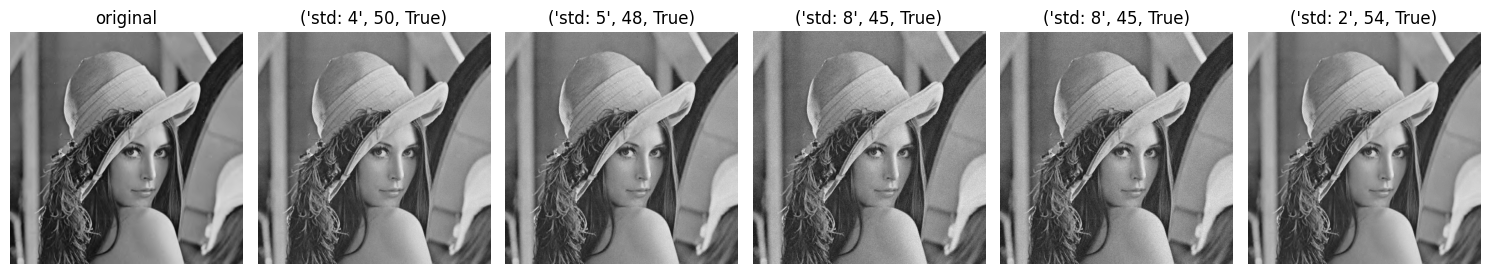



Attack Name: Blur
Average mark found for: 0
Best WPSNR non detected watermark: 44.52668966237813
Best Parameters non detected watermark: sigma: 1
Average WPSNR for non detected watermark (5): 33.88035338206713
Used Parameters for detected watermark: []
Used Parameters for non detected watermark: [('sigma: 5', 29, False), ('sigma: 5', 29, False), ('sigma: 5', 29, False), ('sigma: 1', 44, False), ('sigma: 2', 36, False)]


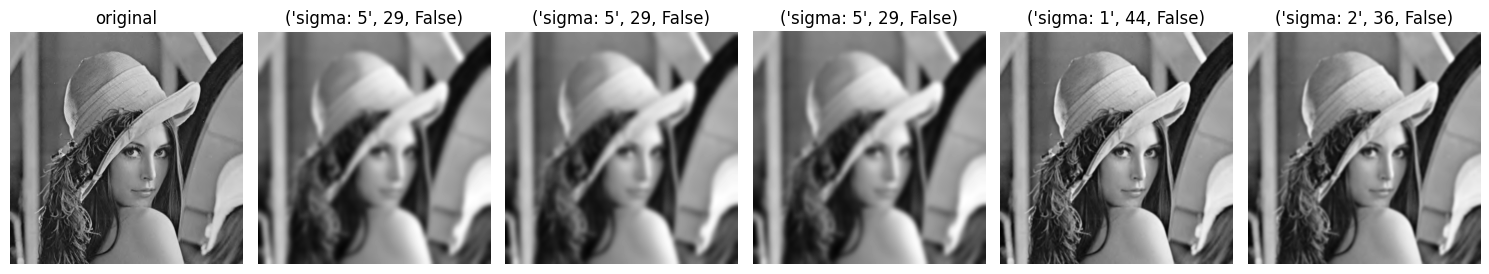



Attack Name: Sharpening
Average mark found for: 0
Best WPSNR non detected watermark: 41.191548351849036
Best Parameters non detected watermark: sigma: 1 alpha: 1
Average WPSNR for non detected watermark (5): 28.879215222890206
Used Parameters for detected watermark: []
Used Parameters for non detected watermark: [('sigma: 2 alpha: 5', 22, False), ('sigma: 1 alpha: 1', 41, False), ('sigma: 3 alpha: 2', 24, False), ('sigma: 5 alpha: 2', 21, False), ('sigma: 1 alpha: 2', 35, False)]


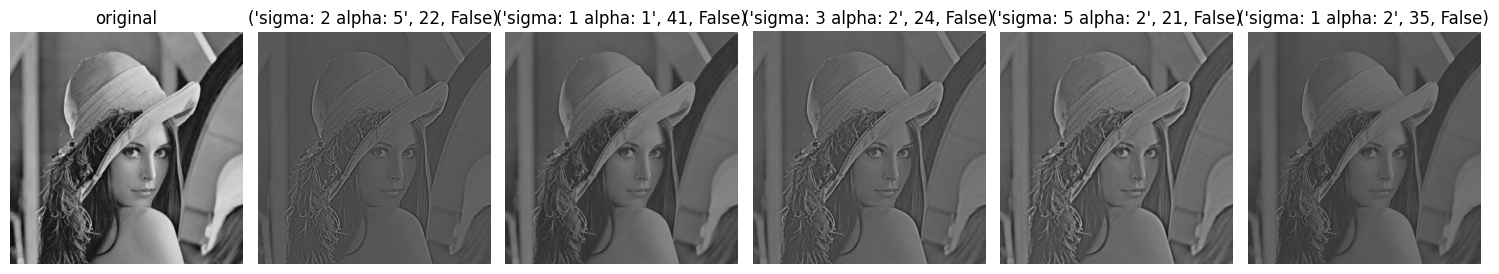



Attack Name: Median
Average mark found for: 0
Best WPSNR non detected watermark: 45.506723086718814
Best Parameters non detected watermark: kernel_size: [5, 3]
Average WPSNR for non detected watermark (5): 40.63721754029438
Used Parameters for detected watermark: []
Used Parameters for non detected watermark: [('kernel_size: [7, 7]', 37, False), ('kernel_size: [3, 7]', 39, False), ('kernel_size: [5, 7]', 38, False), ('kernel_size: [5, 3]', 45, False), ('kernel_size: [3, 5]', 43, False)]


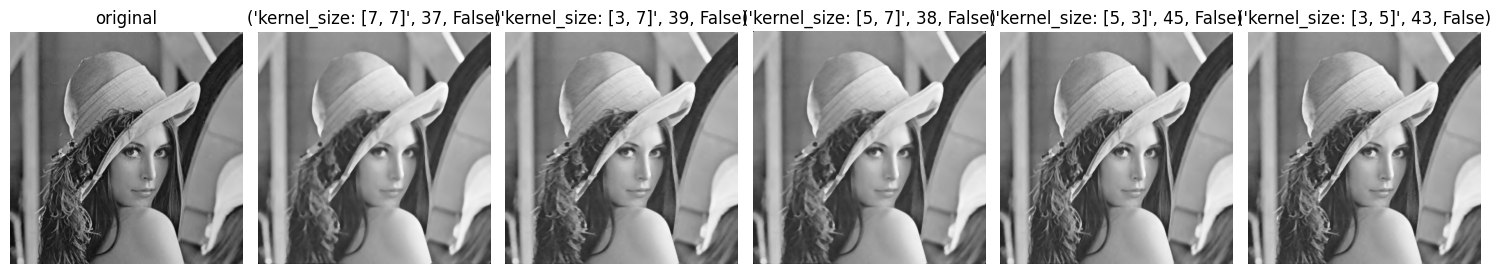



Attack Name: Resizing
Average mark found for: 0
Best WPSNR non detected watermark: 51.88516296044027
Best Parameters non detected watermark: scale: 0.9797202688750133
Average WPSNR for non detected watermark (5): 48.23514676473646
Used Parameters for detected watermark: []
Used Parameters for non detected watermark: [('scale: 0.5881203216864572', 46, False), ('scale: 0.922381693485218', 51, False), ('scale: 0.9797202688750133', 51, False), ('scale: 0.5497342925062315', 44, False), ('scale: 0.6167486868593649', 47, False)]


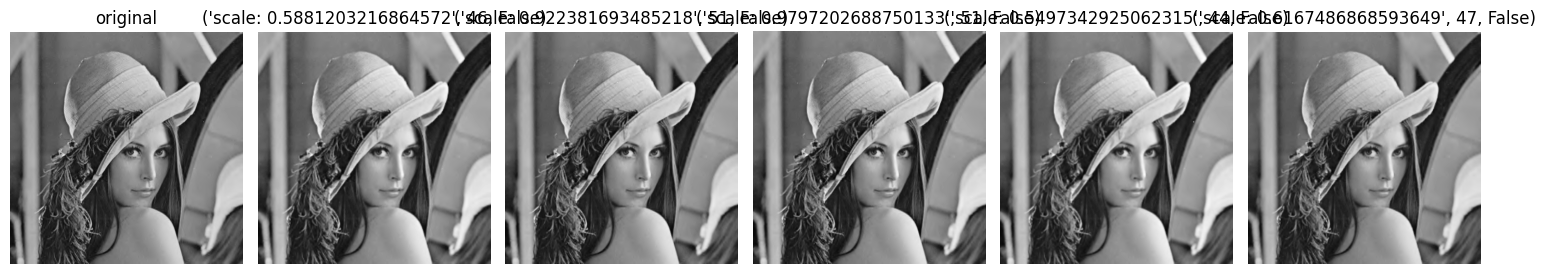



Attack Name: JPEG Compression
Average mark found for: 4
Best WPSNR non detected watermark: 55.2665588606337
Best Parameters non detected watermark: QF: 70
Average WPSNR for non detected watermark (1): 55.2665588606337
Used Parameters for detected watermark: [('QF: 99', 62, True), ('QF: 89', 60, True), ('QF: 92', 60, True), ('QF: 97', 62, True)]
Used Parameters for non detected watermark: [('QF: 70', 55, False)]


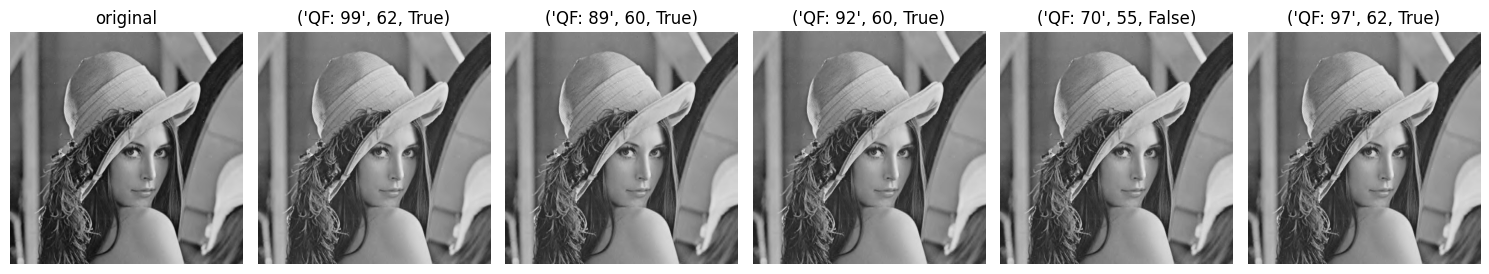



Attack Name: DWT_GAUSS
Average mark found for: 0
Best WPSNR non detected watermark: 48.56899304792988
Best Parameters non detected watermark: sigma: 2
Average WPSNR for non detected watermark (5): 48.386149133661114
Used Parameters for detected watermark: []
Used Parameters for non detected watermark: [('sigma: 3', 48, False), ('sigma: 5', 48, False), ('sigma: 2', 48, False), ('sigma: 4', 48, False), ('sigma: 4', 48, False)]


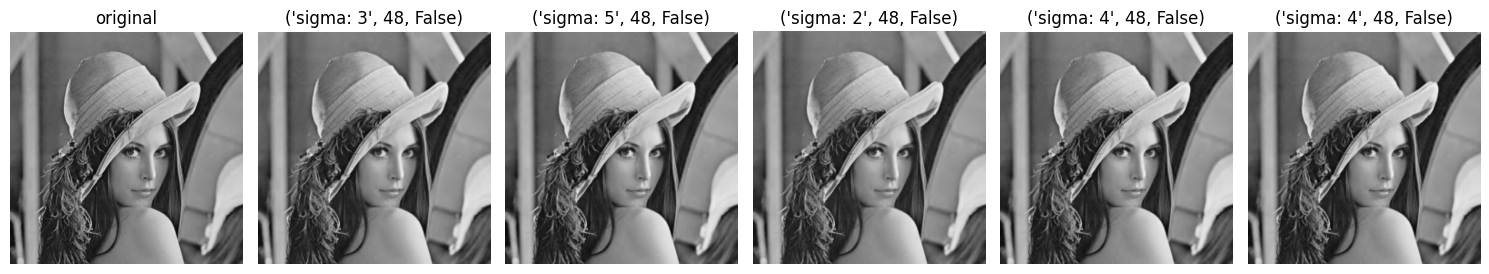

In [155]:
import attacks
from tqdm import tqdm
import importlib
importlib.reload(attacks)




img_path='lena_grey.bmp'
N = 1024

#v = 'additive'
#alpha = 24
v = 'multiplicative'
alpha = 0.5
np.random.seed(seed=123)

image = cv2.imread(img_path, 0)

mark, watermarked1 = embedding(image, N, alpha, v)

total_attacks = 0
total_attacks_mark_found = 0
non_attacked_mark_found = 0
total_wpsnr_non_attacked = 0
total_wpsnr_attacked = 0
total_wpsnr_non_detected = 0 #average wpsnr non detected watermark for attacked images

attack_functions= attacks.random_attack_list()
# print(attack_functions)
progress_bar = tqdm(attack_functions, desc="Applying attacks")


average_attack = {

}

for _, attack_fn in enumerate(progress_bar):
    attack_type_times = 0
    local_wpsnr = 0
    attack_mark_found = 0
    best_wpsnr = 0
    best_params = ""
    average_non_detected_wpsnr = 0
    local_used_params = []  
    #local_used_params_detected = []  
    local_attacked_image = []
    for _ in range(5):
        attack_type_times += 1
        (attacked,attack_name,used_params) = attack_fn(watermarked1)
        local_attacked_image.append(attacked)
        progress_bar.set_description(f"Applying {attack_name}")
        attacked = attacked.astype(np.uint8)
        image = image.astype(np.uint8)

        #detection
        w_ex = detection(image, watermarked1, alpha, N, v)
        w_ex_att = detection(image, attacked, alpha, N, v)
        #wpsnr
        wspnr_watermarked = wpsnr(image, watermarked1)
        wpsnr_attacked = wpsnr(image, attacked)
        print(wpsnr_attacked)

        local_wpsnr += wpsnr_attacked
        total_wpsnr_non_attacked += wspnr_watermarked
        #similarity
        sim_attacked = similarity(w_ex,w_ex_att)
        sim_not_attacked = similarity(mark,w_ex)
        Tau, _ = compute_thr(sim_not_attacked, N, mark, 1000)
        #watermark retrieved?
        #erate status message
        status = "\n"
        status += f"WPSNR non-ATTACKED IMAGE = {wspnr_watermarked}\n"
        status += f"WPSNR ATTACKED IMAGE = {wpsnr_attacked}\n"

        if sim_not_attacked > Tau:
            non_attacked_mark_found += 1
            status += f"Mark found in non-attacked image. SIM = {sim_not_attacked:.6f}\n"
        else:
            status += f"Mark lost in non-attacked image. SIM = {sim_not_attacked:.6f}\n"

        if sim_attacked > Tau:
            attack_mark_found += 1
            local_used_params.append((used_params,int(wpsnr_attacked),True))
            status += f"Mark found in attacked image. SIM = {sim_attacked:.6f}\n"
        else:
            status += f"Mark lost in attacked image. SIM = {sim_attacked:.6f}\n"
            local_used_params.append((used_params,int(wpsnr_attacked),False))
            if wpsnr_attacked > best_wpsnr:
                best_wpsnr = wpsnr_attacked
                best_params = used_params
            average_non_detected_wpsnr += wpsnr_attacked

        status += "--------------------------\n"
        # Print status message
        #progress_bar.write(status)

    average_attack[attack_name] ={
        'attack_type_times':attack_type_times,
        'local_wpsnr':local_wpsnr,
        'attack_mark_found':attack_mark_found,
        'best_params':best_params,
        'best_wpsnr':best_wpsnr,
        'average_non_detected_wpsnr':average_non_detected_wpsnr,
        'local_used_params':local_used_params,
        'attacked_image':local_attacked_image
    }

    total_attacks_mark_found += attack_mark_found
    total_attacks += attack_type_times
    total_wpsnr_attacked += local_wpsnr
    total_wpsnr_non_detected += average_non_detected_wpsnr


print(f"Ratio mark found/total attack in attacked image: {total_attacks_mark_found} / {total_attacks}")
print(f"Ratio mark found/total attack in non-attacked image: {non_attacked_mark_found} / {total_attacks}")
print(f"Average WPSNR in attacked image: {total_wpsnr_attacked /total_attacks}")
print(f"Average WPSNR in non-attacked image: {total_wpsnr_non_attacked/ total_attacks}")
print(f"Average WPSNR for non detected watermark in attacked image: {total_wpsnr_non_detected/total_attacks-total_attacks_mark_found}")
for attack_name, values in average_attack.items():
    print("\n")
    print("Attack Name: "+attack_name)
    print(f"Average mark found for: {values['attack_mark_found']}")
    print(f"Best WPSNR non detected watermark: {values['best_wpsnr']}")
    print(f"Best Parameters non detected watermark: {values['best_params']}")
    non_detected_mark = values['attack_type_times']-values['attack_mark_found']
    if non_detected_mark == 0:
        print(f"Average WPSNR for non detected watermark: {values['average_non_detected_wpsnr']}")#should be 0
    else:
        print(f"Average WPSNR for non detected watermark ({non_detected_mark}): {values['average_non_detected_wpsnr']/non_detected_mark}")  

    print(f"Used Parameters for detected watermark: {list(filter(lambda x:x[2],values['local_used_params']))}")
    print(f"Used Parameters for non detected watermark: {list(filter(lambda x: not x[2],values['local_used_params']))}")
    utility.visualize_images_with_desc([image]+values['attacked_image'], ["original"] + values['local_used_params'])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

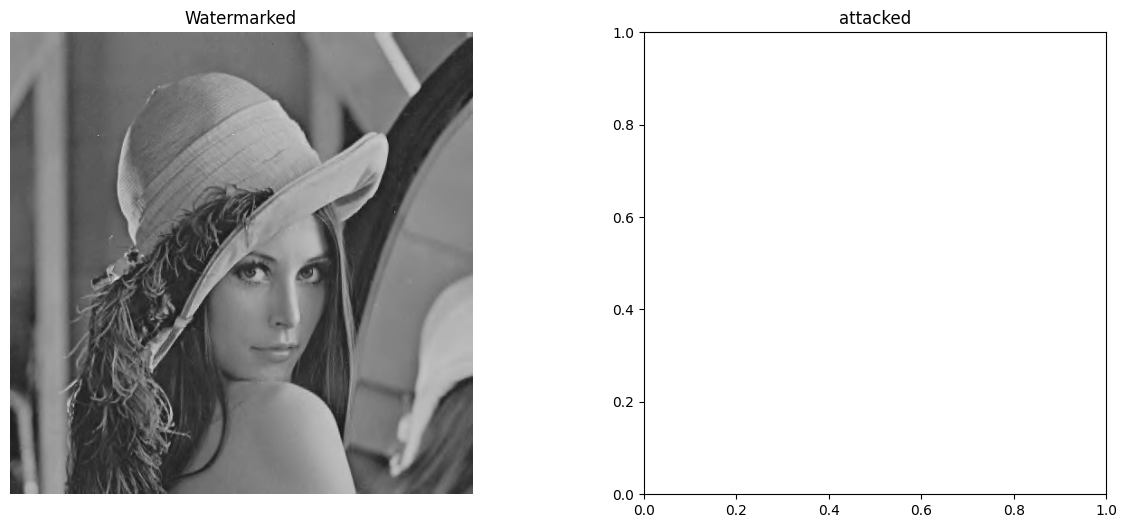

In [117]:
import utility
importlib.reload(attacks)
prova = attacks.apply_gaussian_blur_to_dwt(watermarked1, 2)
utility.visualize_images_with_desc([watermarked1, prova], ['Watermarked', 'attacked'])
